## HW3: Generative Models

In this homework, we will implement deep generative models. This assignments mainly consists of two parts:

  1. Variational Autoencoder (VAE): 
  
      In the VAE section, you will implement a vanilla VAE and a $\beta$-VAE. After training, you need to compute the neg-loglikelihood (NLL) using the importance sampling method. Then, you need to investigate how well the representations of VAE and $\beta$-VAE are disentangled.
  
  2. Generative Adversarial Network (GAN):
  
      In the GAN section, you will implement a DCGAN and an LSGAN.

Submission requirements: you need to submit both of the following files.
  - hw3.ipynb: finish all the requirements and submit this Jupyter file.
  - report.pdf: See report.ipynb for details.

In [1]:
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.distributions import Normal, kl_divergence, Bernoulli
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
import os

## Guidance 0: Dataset

We will use a subset of the [dSprites](https://github.com/deepmind/dsprites-dataset) dataset for the VAE models. dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth independent latent factors. These factors are color, shape, scale, rotation, x and y positions of a sprite. Please run the following cells to make the dataset ready.

In [2]:
# download dataset and prepare dataset directories.
# dir_name="./dataset/dsprites-dataset"
# !git clone https://github.com/deepmind/dsprites-dataset.git $dir_name
#     https://github.com/deepmind/dsprites-dataset.git

In [3]:
class DspritesDataset(Dataset):
    def __init__(self, data_tensor):
        super(DspritesDataset, self).__init__()
        self.data = data_tensor
  
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
device = torch.device('cuda:0') # set it to torch.device('cpu') if you are using cpus
root = os.path.join('./dataset', 'dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
data = np.load(root, encoding='bytes')
imgs = torch.from_numpy(data['imgs']).unsqueeze(1).float()

# dsprites has 6 latent factors, controlling the color, shape, scale, rotation and position of the 
#     Color: white
#     Shape: square, ellipse, heart
#     Scale: 6 values linearly spaced in [0.5, 1]
#     Orientation: 40 values in [0, 2 pi]
#     Position X: 32 values in [0, 1]
#     Position Y: 32 values in [0, 1]
# object. We skip the factor 'rotation' to reduce the dataset size (only take rotation with 0 degrees). 
imgs = imgs.reshape(3, 6, 40, 32, 32, 1, 64, 64).permute(2, 0, 1, 3, 4, 5, 6, 7)[0]
imgs = imgs.reshape(-1, 1, 64, 64)

# randomly split the dataset into training set and test set
num_data = imgs.shape[0]
idx = np.arange(num_data)
np.random.shuffle(idx)
num_train = int(num_data * 0.8)
train_data = imgs[idx[:num_train]]
test_data = imgs[idx[num_train:]]

train_ds = DspritesDataset(train_data)
test_ds = DspritesDataset(test_data)


## Task 1: Variational Autoencoder (VAE)

VAE is a probabilistic generative model which allows to estimate the data distribution, sample data points, and learn representations. The training process of VAE can be described as follows:

- Inference Process:
    - Sample $\mathrm{x}$ from the training set.
    - Infer the approximate posterior with encoder network: $q_{\phi}(\mathrm{z} | \mathrm{x}) = \mathcal{N}(\mathrm{z} \mid \mu_{\phi}(\mathrm{x}), \Sigma_{\phi}(\mathrm{x}))$


- Generation Process:
    - Sample latent variable from the approximate posterior
    - Recover reconstruction $\hat{\mathrm{x}}$ with decoder network: $p_{\theta}(\mathrm{x} ｜ \mathrm{z}) = \mathcal{N}(\mathrm{x} \mid \mu_{\theta}(\mathrm{z}), \sigma)$
                    
                    
- Estimate ELBO and maximize ELBO with gradient ascent:
    - ELBO = $\mathbb{E}_{q_{\phi}(\mathrm{z} \mid \mathrm{x})}[\log p_{\theta}(\mathrm{x} \mid \mathrm{z})] - KL\big(q_{\phi}(\mathrm{z} \mid \mathrm{x}) \parallel p(\mathrm{z})\big)$
    
To evaluate a VAE model, we need to estimate the negative log-likelihood (NLL), $- \log p(x)$, using importance sampling method:
\begin{align*}
-\log p(x) \approx - \big[\log \frac{1}{k}\sum^k_{i=1}\frac{p(\mathrm{x}, \mathrm{z}_i)}{q(\mathrm{z}_i \mid \mathrm{x})}\big]
\end{align*}
where $z_i \sim q(\mathrm{z}_i \mid \mathrm{x})$ and $k$ the number of samples (set $k=50$.)

### Task 1.1 Vanilla VAE

**To-dos**:
- (5 points) Implement the class Encoder: 
  - map the input image of size (64, 64) to a latent vector of size (z_dim,)
- (5 points) Implement the class Decoder: 
  - recover the input image from the sampled latent vector
- Complete the class VAE:
  - (5 points) Complete the **forward()** function 
  - (5 points) Complete the **comp_nll()** function for model evaluation
- (2 points) Generate 16 image samples, plot them in one figure and save the figure
- (5 points) Complete the function **traversal_plots()**

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        """
        You design your own encoder network.

        An example from the Beta-VAE paper is provided below:
          Conv 32x4x4 (channel_out 32, kernel 4, stride 2, padding 1),
          Conv 32x4x4 (channel_out 32, kernel 4, stride 2, padding 1), 
          Conv 64x4x4 (channel_out 64, kernel 4, stride 2, padding 1),
          Conv 64x4x4 (channel_out 64, kernel 4, stride 2, padding 1),
          FC 256 (feature_dim_out 256).
          Non-linearity between layers: ReLU activation.
        """
        ###        Start of the code    ####
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)
        ###        End of the code    ####
    def forward(self, x, testing=True):
        """
        Inputs:
          x: 4D tensor, input images, (B, C, H, W)
          testing: boolean, if it's set to True, it means training phase
        Outputs:
          mu: 2D tensor, mean of the latent distribution
          std: 2D tensor, standard deviations of the latent distribution
        """
        ###        Start of the code    ####
        # x is of shape [batch_size, input_dim]
        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]
        ###        End of the code    ####
        return mu, var

In [6]:
class Decoder(nn.Module):
    def __init__(self,  z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        """
        You design your own decoder network.

        An example provided from the Beta-VAE paper is to reverse
        the encoder defined above using ConvTranspose2d layers.
        """
        ###        Start of the code    ####
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim
        ###        End of the code    ####


    def forward(self, z):
        """
        Inputs:
          z: 2D tensor, latent variable, (B, z_dim)
        Output:
          rec_mu: 4D tensor, reconstructed images, (B, C, H, W)
        """
        ###        Start of the code    ####
        # x is of shape [batch_size, latent_dim]
        hidden = F.relu(self.linear(z))
        # hidden is of shape [batch_size, hidden_dim]
        rec_mu = torch.sigmoid(self.out(hidden))
        # rec_mu is of shape [batch_size, output_dim]
        ###        End of the code    ####
        return rec_mu


In [7]:
class VanillaVAE(nn.Module):
    def __init__(self, z_dim=10, input_dim=64*64, hidden_dim=256*10):
        super(VanillaVAE, self).__init__()
        #input_dim, hidden_dim, z_dim
        self.pic_wh = int(input_dim**0.5)
        self.enc = Encoder(input_dim, hidden_dim, z_dim)
        #z_dim, hidden_dim, output_dim
        self.dec = Decoder(z_dim, hidden_dim, input_dim)

    def forward(self, x, testing=False, k=50):
        """
        Inputs:
          x: 4D tensor, input images, (B, C, H, W)
          testing: boolean, if it's set to True, it means training phase
          k: number of samples
        Output:
          loss: scalar, averaged loss over this batch
          rec_mu: 4D tensor, reconstructed images, (B, C, H, W)
        """
        
        if testing:
            ###        Start of the code    ####
            k = 50 
            x = x.reshape(-1, self.pic_wh*self.pic_wh)
            x = x.repeat(k,1)
            z_mu, z_var = self.enc(x)
            eps = torch.randn_like(z_var)
            z_sample = eps.mul(z_var.mul(0.5).exp_()).add_(z_mu)
            x_sample = self.dec(z_sample)    
            
            
            log_p, log_q, log_p_given_z = self.the_distribtution(x_sample, x, z_sample, z_mu, z_var)
            log_p = log_p.unsqueeze(-1).reshape(-1, k)
            log_q = log_q.unsqueeze(-1).reshape(-1, k)
            log_p_given_z = log_p_given_z.unsqueeze(-1).reshape(-1, k)
            nll = self.comp_nll(log_p, log_q, log_p_given_z)
            ###        End of the code    ####
            return nll
        else:
            ###        Start of the code    ####
            # encode
            k = 50
            x = x.reshape(-1, self.pic_wh*self.pic_wh)
            x = x.repeat(k,1)
            z_mu, z_var = self.enc(x)
            eps = torch.randn_like(z_var)
            z_sample = eps.mul(z_var.mul(0.5).exp_()).add_(z_mu)
            x_sample = self.dec(z_sample)    
            
            
            log_p, log_q, log_p_given_z = self.the_distribtution(x_sample, x, z_sample, z_mu, z_var)
            log_p = log_p.unsqueeze(-1).reshape(-1, k)
            log_q = log_q.unsqueeze(-1).reshape(-1, k)
            log_p_given_z = log_p_given_z.unsqueeze(-1).reshape(-1, k)
            loss = self.elbo_loss(log_p, log_q, log_p_given_z)


            x_sample = x_sample.reshape(k,-1,self.pic_wh,self.pic_wh).mean(0).unsqueeze(1)
            ###        End of the code    ####

            return loss, x_sample
        
    def comp_nll(self, log_p, log_q, log_p_given_z):
        """
        Compute the NLL using importance sampling.
        Output:
        nll: 1D tensor, (B, ), negative marginal log-likelihood
        """
        ###        Start of the code    ####
        numOfSamples = log_p.shape[1]
        elbo = log_p + log_p_given_z - log_q
        log_p_x = - np.log(numOfSamples) + torch.logsumexp(elbo, dim=1)
        nll = -log_p_x.unsqueeze(-1)
        ###        End of the code    ####
        return  nll
    
    def elbo_loss(self, log_p, log_q, log_p_given_z):
        def log_mean_exp(x):
            max_, _ = torch.max(x, 1, keepdim=True)
            return torch.log(torch.mean(torch.exp(x - max_), 1)) + torch.squeeze(max_)
        elbo = (log_p + log_p_given_z - log_q)
        elbo = log_mean_exp(elbo)
        return -1*elbo.mean()    


    def the_distribtution(self, x_sample, x, z_sample, mu, log_var):
        def ll_gaussian(y, mu, log_var):
            return -0.5 * (
      log_var.sum(1) + ((y - mu).pow(2) / torch.exp(log_var)).sum(1))
        
        def ll_bernoulli(x_sample, x):
            loss = -F.relu(x_sample) + torch.mul(x, x_sample) -torch.log(1. + torch.exp(-x_sample.abs()))
            loss = loss.sum(-1)
            return loss
        log_p_given_z = ll_bernoulli(x_sample, x)
        log_p = ll_gaussian(z_sample, torch.zeros(mu.shape).cuda(), torch.ones(mu.shape, dtype=torch.float).cuda())
        log_q = ll_gaussian(z_sample, mu, log_var)

        return log_p, log_q, log_p_given_z

A correctness checking snippet for NLL calculation is provided below. It assumes that the function **comp_nll( )** takes the $\log p(\mathrm{z})$, the $\log q(\mathrm{z} \mid \mathrm{x})$, and the $\log p(\mathrm{x} \mid \mathrm{z})$ as input. Given $3$ datapoints with $5$ samples for each of them, if your imeplementation is correct, you will get the NLL results as follows:

```
tensor([[-1.0962],
        [ 1.2672],
        [-0.5142]])
```

In [8]:
torch.manual_seed(0)
log_p = torch.randn((3, 5), dtype=torch.float)
log_q = torch.randn((3, 5), dtype=torch.float)
log_p_given_z = torch.randn((3, 5), dtype=torch.float)

net = VanillaVAE()
nll = net.comp_nll(log_p, log_q, log_p_given_z)
print(nll)

tensor([[-1.0962],
        [ 1.2672],
        [-0.5142]])


A simple **train_model()** and a simple **eval_model()** helper function are provided as below. Feel free to modify them upon your needs.

In [9]:
def train_model(model, dataloader, optimizer, e):
    """
    Inputs:
    model: nn.Module, model to be trained
    dataloader: dataset iterator
    optimizer: optimizer
    e: current epoch, used to calculate the current iteration step
    """
    model.train()
    train_loss = 0.
    for i, img in enumerate(dataloader):
        step = e*len(dataloader) + i
        loss, rec = net(img.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach()

        if step % 500 == 0:    
            print('Steps:\t{}/{},\tloss:{:.6f}'.format(step, len(dataloader)*epochs, loss))
            rec_vis = vutils.make_grid(torch.cat([img[:4].cpu(), rec[:4].detach().cpu()], dim=0), nrow=4, pad_value=1)
            plt.imshow(rec_vis.permute(1,2,0))
            plt.show()

    train_loss = train_loss / float(len(dataloader))
    return model, train_loss

In [10]:
def eval_model(model, dataloader, k=1):
    """
    Inputs:
    model: nn.Module, model to be trained
    dataloader: iterator, dataset loader
    k: importance sampling sample numbers
    I make the k=1 because I do sampling in the learning function
    """
    nll = 0.
    model.eval()
    with torch.no_grad():
        for i, img in enumerate(dataloader):
            B, C, H, W = img.shape
            img = img.unsqueeze(1).expand(-1, k, -1, -1, -1).reshape(B*k, C, H, W)
            img = img.to(device)
            nll_batch = model(img, testing=True)
            nll += nll_batch.mean().detach()

    return nll

The main training script is provided as follows. At the end of the training, the loss curve and NLL curve will be plotted and saved.

Feel free to modify it, and make sure your model has been trained till fully converged.

In [11]:
# hyperparams
epochs, z_dim, batch_size, lr, optimizer = 15, 10, 64, 1e-4, torch.optim.Adam

In [12]:
dl_train = DataLoader(train_ds, batch_size = batch_size, num_workers=16, shuffle=True, drop_last=True)
dl_test = DataLoader(test_ds, batch_size = 4, num_workers=16, shuffle=True, drop_last=True)


net = VanillaVAE(z_dim)
net = net.to(device)
optimizer = optimizer(net.parameters(), lr=lr)

Steps:	0/3450,	loss:3816.182373


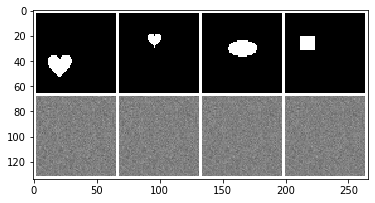

Epoch:	0/15,	nll:2884.702393
Epoch:	1/15,	nll:2876.055176
Steps:	500/3450,	loss:2801.359375


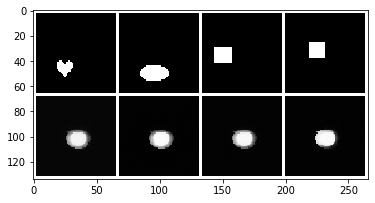

Epoch:	2/15,	nll:2870.656250
Epoch:	3/15,	nll:2859.820068
Steps:	1000/3450,	loss:2779.800537


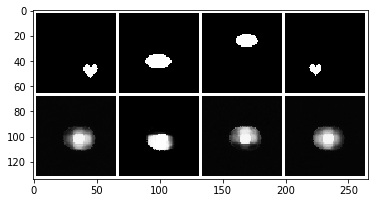

Epoch:	4/15,	nll:2853.185303
Epoch:	5/15,	nll:2847.338379
Steps:	1500/3450,	loss:2747.376709


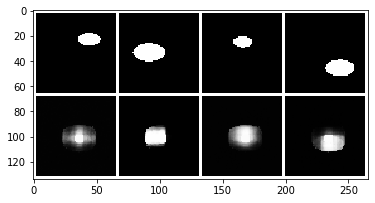

Epoch:	6/15,	nll:2842.906006
Epoch:	7/15,	nll:2840.534668
Steps:	2000/3450,	loss:2767.825195


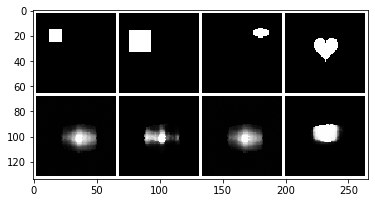

Epoch:	8/15,	nll:2837.714600
Epoch:	9/15,	nll:2834.775635


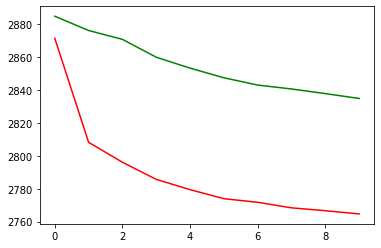

Steps:	2500/3450,	loss:2786.382324


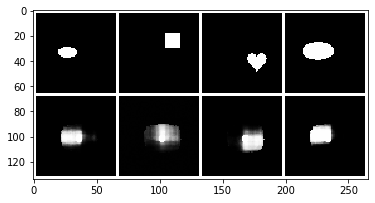

Epoch:	10/15,	nll:2835.127441
Epoch:	11/15,	nll:2831.383301
Epoch:	12/15,	nll:2831.979248
Steps:	3000/3450,	loss:2764.519043


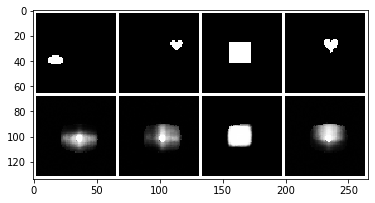

Epoch:	13/15,	nll:2828.666504
Epoch:	14/15,	nll:2826.437988


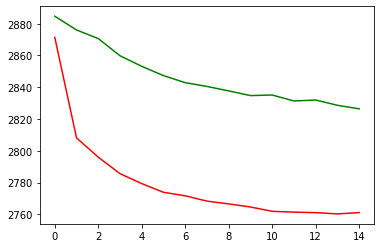

<Figure size 432x288 with 0 Axes>

In [13]:
nll_list = []
train_loss = []
for e in range(epochs):
    net, loss = train_model(net, dl_train, optimizer, e)
    train_loss.append(loss.to(device).item())

    nll = eval_model(net, dl_test)
    nll = nll / float(len(dl_test))
    nll_list.append(nll.to(device).item())
    print('Epoch:\t{}/{},\tnll:{:.6f}'.format(e, epochs, np.mean(nll.item())))
    if (e+1) % 10 == 0:
        plt.plot(np.arange(len(train_loss)), train_loss, 'r-', np.arange(len(nll_list)), nll_list, 'g-')
        plt.show()
    
plt.plot(np.arange(len(train_loss)), train_loss, 'r-', np.arange(len(nll_list)), nll_list, 'g-')
plt.show()
plt.savefig('./results/vae_curves.png')

Generate and visualize images by sampling from the prior distribution:

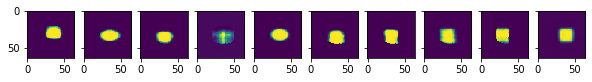

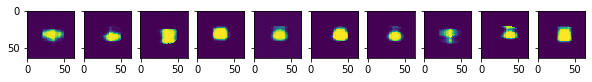

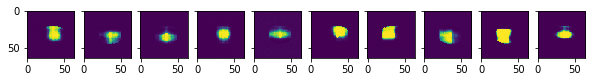

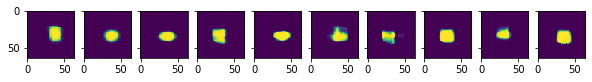

In [ ]:
### please put your samples generating codes here ###
# Used Code from the following link
# https://sebastianraschka.com/deep-learning-resources.html
for i in range(5):
    
    n_images = 10
    rand_features = torch.randn(n_images, z_dim).to(device)
    new_images = net.dec(rand_features)

    image_width = 64

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]
    
    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)))
        
    plt.show()

To investigate the disentanglement property of the vanilla VAE, we visualize how the reconstruction changes along with the traversal of latent units.

This can be done by the following steps:
  - Sample the latent variable from the approximate posterior,
  - Change the value of one element by traversing over some range (three standard deviations around the unit Gaussian prior mean) while keeping the remaining latent units fixed,
  - Recover images from the modified latent variable.
  
The skeleton of the function **traversal_plots()** has been provided below, please complete it and plot traversal visualization of every single latent unit with vanilla VAE.

In [20]:
def traversal_plots(net, img, z_dim):
    torch.manual_seed(0)
    assert img.shape[0] == 1, "only support one image for traversal experiment"
    # infer the approximate posterior
    pic_wh = 64
    z_mu, z_var = net.enc(img.view(-1,pic_wh*pic_wh)) 
    z_std = z_var
    # sample from the approximate posterior
    eps = torch.randn_like(z_var)
    z = z_var.mul(0.5).exp_().add_(z_mu)
    std = z_var.mul(0.5).exp_()
    
    # traverse the latent space
    interpolation = torch.linspace(-3., 3., steps=10, device=img.device)
    rec_mus = []
    for dim in range(z_dim):
        for val in interpolation:
            ###   modify value of one latent unit
            y = z.clone()
            y[:, dim] = val
            
            ### generate images with modified latentd
            x_sample = net.dec(y)
            x_sample = x_sample.reshape(pic_wh, pic_wh)
            img = x_sample.detach().to(torch.device('cpu'))
            rec_mus.append(img.view(64, 64))
    
    return rec_mus

z_dim:  10


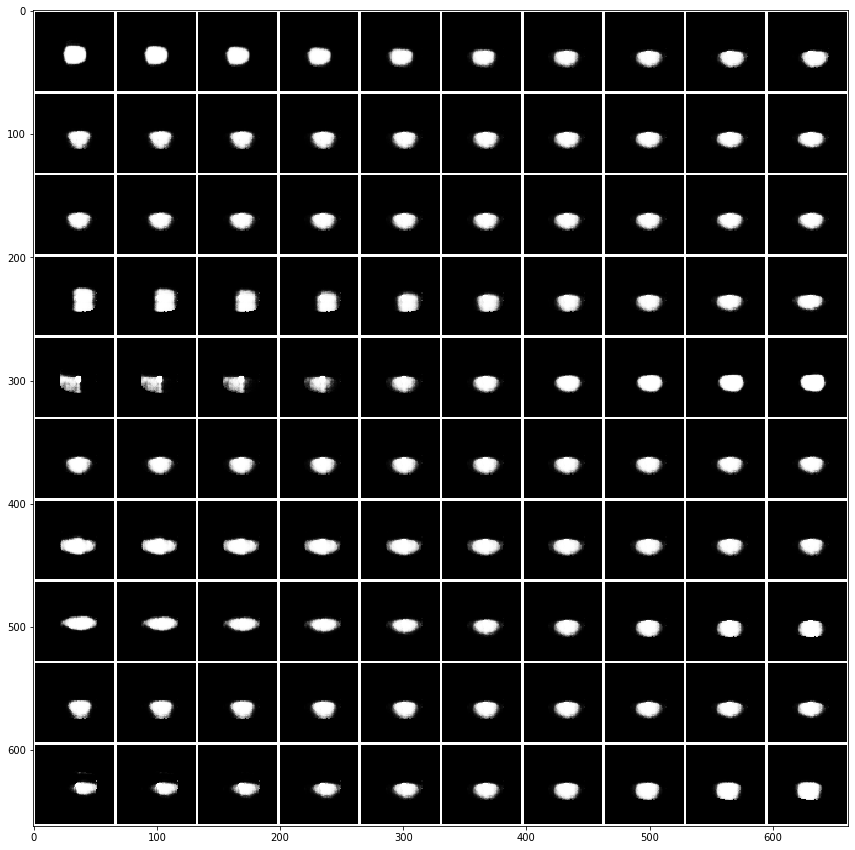

In [21]:
idx = np.random.choice(np.arange(len(test_ds))) # randomly take one image from test set
img_val = test_ds[idx]
mu, std = net.enc(img_val.view(-1,64*64).cuda()) 
print("z_dim: ", z_dim)
tra_imgs = traversal_plots(net, img_val[None, ...].to(device), z_dim)
tra_imgs = torch.stack(tra_imgs).unsqueeze(1)
tra_vis = vutils.make_grid(tra_imgs.data.cpu(), nrow=z_dim, pad_value=1)
plt.figure(figsize=(15, 15))
plt.imshow(tra_vis[0], cmap='gray')
plt.savefig('./vae_traversal.png')

### Task 1.2 Beta-VAE

[Beta-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl) encourages the model to learn disentangled representations by modifying the ELBO:

\begin{align*}
 \mathcal{L} &= \mathbb{E}_{q_{\phi}(\mathrm{z} \mid \mathrm{x})}[\log p_{\theta}(\mathrm{x} \mid \mathrm{z})] - \beta * KL\big(q_{\phi}(\mathrm{z} \mid \mathrm{x}) \parallel p(\mathrm{z})\big)
\end{align*}

A disentangled representation can be deﬁned as one where single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors, [Bengio et al., 2013](https://arxiv.org/pdf/1206.5538.pdf).

As an example of visualized comparison on disentanglement learned by vanilla VAE and Beta-VAE shown below, it can be seen that Beta-VAE provides better disentanglement:

<img src="./imgs/disentangle.png" alt="Drawing" style="width: 800px;"/>

**To-dos**:

- Implement the class BetaVAE, You can reuse the modules you have defined in task 1.1.
- Implement the training and evaluation script, plot and save the loss/NLL curve.
- (20 points) Find the $\beta$ values by visual inspection that achieves the best disentanglement performance: it needs to be shown in your traversal plot that all of the generative factors ('shape', 'scale', 'posX', and 'posY') has their corresponding sensitive latent units through the traversal of the latent variable.

## Task 2: Generative Adversary Network (GAN)

In a GAN, two different networks are built to compete against each other: the generator tries to generate images that can fool the discriminator, and the discriminator tries to classify whether a given image is generated from the generator or sampled from the dataset. The objective function is :

\begin{align*}
\underset{G}{\text{minimize}}\ \underset{D}{\text{maximize}}\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]
\end{align*}

In the GAN section, we will use the MNIST dataset:

In [17]:
img_size = 28
batch_size = 32
ds_train = datasets.MNIST('./dataset/MNIST', transform=transforms.ToTensor(), download=True)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

## Task 2.1 Deep Convolutional GANs ( DCGAN )

**To-dos**:
- (5 points) Implement the class Generator.
- (5 points) Implement the class Discriminator.
- (5 points) Implement the training script, and finish the training process.
- (5 points) Plot and save the loss curves, 16 fake image samples generated by the generator.

In [18]:
class Discriminator(nn.Module):
  def __init__(self, ):
    super(Discriminator, self).__init__()
    """
    You can design your discriminator network. An example is provided as follows:
    
    Conv2D: 32 Filters, 5x5, Stride 1, padding 0
    Leaky ReLU(alpha=0.01)
    Max Pool 2x2, Stride 2
    Conv2D: 64 Filters, 5x5, Stride 1, padding 0
    Leaky ReLU(alpha=0.01)
    Max Pool 2x2, Stride 2
    Flatten
    Fully Connected with output size 4 x 4 x 64
    Leaky ReLU(alpha=0.01)
    Fully Connected with output size 1
    """
    ###        Start of the code    ####
      
      
      
      
    ###        End of the code    #### 
    
  def forward(self, x):
    """
    Inputs:
      x: 4D tensor, (B, C, H, W)
    Output: 1D tensor, (B,)
    """
    
    ###        Start of the code    ####
      
      
      
      
    ###        End of the code    #### 
    
    return self.enc(x)

In [19]:
class Generator(nn.Module):
  def __init__(self, ):
    super(Generator, self).__init__()
    """
    You can design your generator network. An example is provided as follows:
    
    Fully connected with output size 1024
    ReLU
    BatchNorm
    Fully connected with output size 7 x 7 x 128
    ReLU
    BatchNorm
    Resize into Image Tensor of size 7, 7, 128
    Conv2D^T (transpose): 64 filters of 4x4, stride 2
    ReLU
    BatchNorm
    Conv2d^T (transpose): 1 filter of 4x4, stride 2
    TanH
    """
    ###        Start of the code    ####
      
      
      
      
    ###        End of the code    #### 
  def forward(self, z):
    """
    Inputs:
      z: 2D tensor, latent variable, (B, z_dim)
    Output: 4D tensor, fake images, (B, C, H, W)
    """
    ###        Start of the code    ####
      
      
      
      
    ###        End of the code    #### 
    
    return self.enc(z).reshape(-1, 28, 28)

## Task 2.2  Least Squares GAN ( LSGAN )

[LSGAN](https://arxiv.org/pdf/1611.04076.pdf) provides a more stable loss function:

\begin{align*}
\text{Generator loss:} && \ell_G  &=  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right] \\
\text{Discriminator loss:} && \ell_D &= \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]
\end{align*}

**To-dos**:
- (2 points) Implement the LSGAN, you can build your LSGAN based on the DCGAN implemented in the task 2.1.
- Implement the training script, and finish the training process.
- (3 points) Plot and save the loss curves, 16 fake image samples generated by the LSGAN generator.


*Reminder*: this is the end of homework 3, please do remember attach the results plots into the report.ipynb file, and submit a report.pdf along with this Jupyter file.